In [1]:
import pandas as pd


train_transaction = pd.read_csv(f"train_transaction.csv")
test_transaction  = pd.read_csv(f"test_transaction.csv")

print(train_transaction.shape) #590540 row dan 393 feature + 1 target
print(test_transaction.shape) #506691 row dan 393 feature

(100000, 394)
(50000, 393)


In [2]:
train_transaction.head() #isFraud adalah target featurenya

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3166669,0,3951780,100.000,R,8695,170.0,150.0,visa,226.0,...,0.0,300.0,300.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3076194,0,1877432,250.000,R,3821,111.0,150.0,mastercard,219.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3175028,1,4206969,129.426,C,1164,545.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3123699,0,2754954,500.000,R,13432,399.0,150.0,american express,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3043546,0,1302456,150.000,R,16566,583.0,150.0,mastercard,224.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_transaction.head() #uji data baru, setelah pembuatan model machine learningnya

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3744294,21149854,330.00,W,17868,148.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3817708,23739800,77.00,W,3576,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3813310,23591626,77.95,W,7504,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4032703,31005734,59.00,W,10112,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3936793,27877283,117.00,W,16770,310.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_transaction.shape

(100000, 394)

In [5]:
test_transaction.shape

(50000, 393)

In [6]:
train_transaction.isnull().sum()

TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
V335              85867
V336              85867
V337              85867
V338              85867
V339              85867
Length: 394, dtype: int64

In [7]:
# ====================================================
# STEP 1: Import Libraries & Check GPU Availability
# ====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve, precision_recall_curve,
                             average_precision_score)
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("XGBoost Version:", xgb.__version__)
try:
    # Test GPU
    test_params = {'tree_method': 'gpu_hist', 'device': 'cuda'}
    GPU_AVAILABLE = True
    print("✅ GPU is available! Using gpu_hist")
except:
    GPU_AVAILABLE = False
    print("❌ GPU not available. Using CPU (hist)")

print(f"\nTrain shape: {train_transaction.shape}")
print(f"Test shape: {test_transaction.shape}")


XGBoost Version: 3.1.2
✅ GPU is available! Using gpu_hist

Train shape: (100000, 394)
Test shape: (50000, 393)


TARGET DISTRIBUTION (isFraud)
Non-Fraud (0): 96,452 (96.45%)
Fraud (1): 3,548 (3.55%)

Imbalance Ratio: 1:27


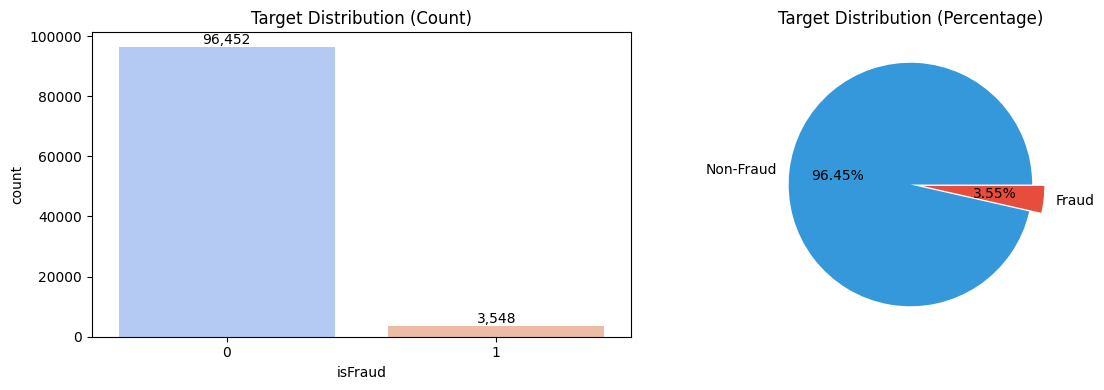

In [8]:
# ====================================================
# STEP 2: Exploratory Data Analysis (EDA)
# ====================================================

# Check target distribution (Fraud vs Non-Fraud)
print("=" * 50)
print("TARGET DISTRIBUTION (isFraud)")
print("=" * 50)
target_counts = train_transaction['isFraud'].value_counts()
target_pct = train_transaction['isFraud'].value_counts(normalize=True) * 100
print(f"Non-Fraud (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Fraud (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{target_counts[0]//target_counts[1]}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
sns.countplot(x='isFraud', data=train_transaction, ax=axes[0], palette='coolwarm')
axes[0].set_title('Target Distribution (Count)')
axes[0].set_xlabel('isFraud')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

# Pie chart
axes[1].pie(target_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', 
            colors=['#3498db', '#e74c3c'], explode=[0, 0.1])
axes[1].set_title('Target Distribution (Percentage)')

plt.tight_layout()
plt.show()

In [9]:
# ====================================================
# STEP 3: Data Preprocessing
# ====================================================

# Separate features and target
X = train_transaction.drop(['isFraud', 'TransactionID'], axis=1)
y = train_transaction['isFraud']
X_test_final = test_transaction.drop(['TransactionID'], axis=1)
test_ids = test_transaction['TransactionID']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test_final.shape}")

# Identify column types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Categorical columns: {categorical_cols}")

Features shape: (100000, 392)
Target shape: (100000,)
Test features shape: (50000, 392)

Numerical columns: 378
Categorical columns: 14
Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [10]:
# ====================================================
# STEP 4: Handle Missing Values & Encode Categoricals
# ====================================================

# Check missing values percentage
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
print("Top 20 columns with highest missing values (%):")
print(missing_pct.head(20))

# Drop columns with >90% missing values
high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
print(f"\nDropping {len(high_missing_cols)} columns with >90% missing values")

X = X.drop(columns=high_missing_cols)
X_test_final = X_test_final.drop(columns=high_missing_cols)

print(f"New features shape: {X.shape}")

Top 20 columns with highest missing values (%):
dist2    93.649
D7       93.334
D13      89.614
D14      89.468
D12      89.120
D6       87.674
D8       87.170
D9       87.170
V148     85.940
V147     85.940
V141     85.940
V140     85.940
V153     85.940
V158     85.940
V163     85.940
V155     85.940
V157     85.940
V161     85.940
V142     85.940
V138     85.940
dtype: float64

Dropping 2 columns with >90% missing values
New features shape: (100000, 390)
New features shape: (100000, 390)


In [11]:
# ====================================================
# STEP 5: Label Encoding for Categorical Columns
# ====================================================

# Update categorical columns list after dropping
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Combine train and test for consistent encoding
    combined = pd.concat([X[col].astype(str), X_test_final[col].astype(str)])
    le.fit(combined)
    
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))
    label_encoders[col] = le
    
print(f"\n✅ Encoded {len(categorical_cols)} categorical columns")
print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test_final.shape}")

Categorical columns to encode: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

✅ Encoded 14 categorical columns
Final X shape: (100000, 390)
Final X_test shape: (50000, 390)

✅ Encoded 14 categorical columns
Final X shape: (100000, 390)
Final X_test shape: (50000, 390)


In [12]:
# ====================================================
# STEP 6: Fill Remaining Missing Values
# ====================================================

# Fill numerical missing values with median
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        X_test_final[col] = X_test_final[col].fillna(median_val)

print(f"Missing values in X after filling: {X.isnull().sum().sum()}")
print(f"Missing values in X_test after filling: {X_test_final.isnull().sum().sum()}")

Missing values in X after filling: 0
Missing values in X_test after filling: 498


In [13]:
# ====================================================
# STEP 7: Train-Validation Split
# ====================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Stratified split to maintain class distribution
)

print("Train-Validation Split:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\ny_val distribution:\n{y_val.value_counts(normalize=True)}")

Train-Validation Split:
X_train: (80000, 390)
X_val: (20000, 390)
y_train distribution:
isFraud
0    0.964525
1    0.035475
Name: proportion, dtype: float64

y_val distribution:
isFraud
0    0.9645
1    0.0355
Name: proportion, dtype: float64


In [14]:
# ====================================================
# STEP 8: Baseline XGBoost Model
# ====================================================

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Baseline model parameters (using CPU - hist method)
baseline_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    'tree_method': 'hist',  # CPU method
    'enable_categorical': False
}

print("💻 Using CPU (hist tree method)")

# Train baseline model
print("\n" + "="*50)
print("TRAINING BASELINE MODEL")
print("="*50)

baseline_model = XGBClassifier(**baseline_params)
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=20
)

# Baseline predictions
y_val_pred_proba = baseline_model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"\n🎯 Baseline Validation ROC-AUC: {baseline_auc:.4f}")

Scale pos weight: 27.19
💻 Using CPU (hist tree method)

TRAINING BASELINE MODEL
[0]	validation_0-auc:0.84352	validation_1-auc:0.84357
[0]	validation_0-auc:0.84352	validation_1-auc:0.84357
[20]	validation_0-auc:0.90916	validation_1-auc:0.89701
[20]	validation_0-auc:0.90916	validation_1-auc:0.89701
[40]	validation_0-auc:0.93034	validation_1-auc:0.90775
[40]	validation_0-auc:0.93034	validation_1-auc:0.90775
[60]	validation_0-auc:0.94813	validation_1-auc:0.91288
[60]	validation_0-auc:0.94813	validation_1-auc:0.91288
[80]	validation_0-auc:0.96067	validation_1-auc:0.91682
[80]	validation_0-auc:0.96067	validation_1-auc:0.91682
[99]	validation_0-auc:0.96753	validation_1-auc:0.91807
[99]	validation_0-auc:0.96753	validation_1-auc:0.91807

🎯 Baseline Validation ROC-AUC: 0.9181

🎯 Baseline Validation ROC-AUC: 0.9181


In [15]:
# ====================================================
# STEP 9: Hyperparameter Tuning (Grid Search)
# ====================================================
from sklearn.model_selection import GridSearchCV

print("="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Define parameter grid (simplified for faster tuning)
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
}

# Base estimator
xgb_estimator = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    tree_method='hist',  # Change to 'gpu_hist' for GPU
    enable_categorical=False
)

# Grid Search with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

# Fit on training data (using a sample for faster tuning)
sample_size = min(100000, len(X_train))
X_sample = X_train.sample(n=sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

print(f"\nRunning Grid Search on {sample_size:,} samples...")
grid_search.fit(X_sample, y_sample)

print("\n" + "="*50)
print("BEST PARAMETERS FOUND:")
print("="*50)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV ROC-AUC: {grid_search.best_score_:.4f}")

HYPERPARAMETER TUNING

Running Grid Search on 80,000 samples...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Running Grid Search on 80,000 samples...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: 

In [ ]:
# ====================================================
# STEP 10: Train Final Model with Best Parameters
# ====================================================

print("="*50)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*50)

# Get best parameters and add additional params
best_params = grid_search.best_params_.copy()
best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    'tree_method': 'hist',  # Change to 'gpu_hist' for GPU
    'enable_categorical': False,
    'early_stopping_rounds': 50
})

# Train final model on full training data
final_model = XGBClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=20
)

# Final validation predictions
y_val_pred_proba_final = final_model.predict_proba(X_val)[:, 1]
y_val_pred = final_model.predict(X_val)

final_auc = roc_auc_score(y_val, y_val_pred_proba_final)
print(f"\n🎯 Final Model Validation ROC-AUC: {final_auc:.4f}")
print(f"📈 Improvement over baseline: {(final_auc - baseline_auc) * 100:.2f}%")

In [ ]:
# ====================================================
# STEP 11: Model Evaluation Metrics
# ====================================================

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)

# 1. Classification Report
print("\n📊 CLASSIFICATION REPORT:")
print("-" * 40)
print(classification_report(y_val, y_val_pred, target_names=['Non-Fraud', 'Fraud']))

# 2. Confusion Matrix
print("\n🔢 CONFUSION MATRIX:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# 3. Additional Metrics
tn, fp, fn, tp = cm.ravel()
print(f"\n📈 ADDITIONAL METRICS:")
print(f"  True Negatives: {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives: {tp:,}")
print(f"\n  Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")
print(f"  Precision (Fraud): {tp/(tp+fp):.4f}")
print(f"  Recall (Fraud): {tp/(tp+fn):.4f}")
print(f"  F1-Score (Fraud): {2*tp/(2*tp+fp+fn):.4f}")
print(f"  ROC-AUC: {final_auc:.4f}")

# Average Precision Score (PR-AUC)
ap_score = average_precision_score(y_val, y_val_pred_proba_final)
print(f"  PR-AUC (Average Precision): {ap_score:.4f}")

In [ ]:
# ====================================================
# STEP 12: Visualization - ROC Curve & Confusion Matrix
# ====================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Non-Fraud', 'Pred: Fraud'],
            yticklabels=['Actual: Non-Fraud', 'Actual: Fraud'])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba_final)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14)
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba_final)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
axes[2].fill_between(recall, precision, alpha=0.3, color='green')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall', fontsize=12)
axes[2].set_ylabel('Precision', fontsize=12)
axes[2].set_title('Precision-Recall Curve', fontsize=14)
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ====================================================
# STEP 13: Feature Importance
# ====================================================

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_n = 20
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance.head(top_n),
    palette='viridis'
)
plt.title(f'Top {top_n} Most Important Features', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n📋 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

In [ ]:
# ====================================================
# STEP 14: Predict on Test Data & Create Submission
# ====================================================

print("="*50)
print("PREDICTING ON TEST DATA")
print("="*50)

# Predict probabilities on test data
test_predictions = final_model.predict_proba(X_test_final)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions
})

print(f"\nSubmission shape: {submission.shape}")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['isFraud'].describe())

# Save submission
submission.to_csv('./submission_xgboost.csv', index=False)
print("\n✅ Submission saved to 'submission_xgboost.csv'")

In [ ]:
# ====================================================
# STEP 15: Model Summary
# ====================================================

print("="*60)
print("📊 FINAL MODEL SUMMARY")
print("="*60)
print(f"""
Dataset Information:
--------------------
• Training samples: {len(X_train):,}
• Validation samples: {len(X_val):,}
• Test samples: {len(X_test_final):,}
• Number of features: {X_train.shape[1]}

Class Distribution (Training):
------------------------------
• Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)
• Fraud: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)

Best Hyperparameters:
--------------------""")
for param, value in grid_search.best_params_.items():
    print(f"• {param}: {value}")
    
print(f"""
Performance Metrics:
--------------------
• ROC-AUC (Baseline): {baseline_auc:.4f}
• ROC-AUC (Final): {final_auc:.4f}
• PR-AUC: {ap_score:.4f}
• Precision (Fraud): {tp/(tp+fp):.4f}
• Recall (Fraud): {tp/(tp+fn):.4f}
• F1-Score (Fraud): {2*tp/(2*tp+fp+fn):.4f}

Output Files:
-------------
• submission_xgboost.csv - Test predictions
""")
print("="*60)